<a href="https://colab.research.google.com/github/Gholamrezadar/triangle_keypoints_detection/blob/main/triangle_keypoint_detection_bahbah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triangle Keypoint Detection
Dataset Link: https://huggingface.co/datasets/Gholamreza/triangle_keypoints/resolve/main/all.zip?download=true

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image

In [ ]:
torch

<module 'torch' from '/usr/local/lib/python3.10/dist-packages/torch/__init__.py'>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

# seed everything
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

## Loading the data

In [ ]:
!curl -L https://huggingface.co/datasets/Gholamreza/triangle_keypoints/resolve/main/all.zip?download=true --output all.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1192  100  1192    0     0   5521      0 --:--:-- --:--:-- --:--:--  5518
100 21.9M  100 21.9M    0     0  31.5M      0 --:--:-- --:--:-- --:--:-- 31.5M


In [ ]:
!mkdir data
!unzip all.zip -d data
!unzip data/train.zip -d data
!unzip data/test.zip -d data
!unzip data/valid.zip -d data


mkdir: cannot create directory ‘data’: File exists
Archive:  all.zip
replace data/test.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import json

class TriangleDataset(Dataset):
    def __init__(self, data_dir, label_dir, transform=None):
        self.directory = data_dir
        self.transform = transform
        with open(label_dir, "r") as f:
            self.json = json.load(f)

    def __len__(self):
        return len(self.json)

    def __getitem__(self, idx):
        # read image using pil
        image = Image.open(self.directory + self.json[idx]['image'])

        # apply transform
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(np.array(image)).permute(2, 0, 1).float()

        # read label using json
        label = self.json[idx]['points']
        label = torch.tensor(label).float()

        return image, label

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
train_dataset = TriangleDataset('data/', 'data/train.json', transform=transform)
X, y = train_dataset[1]
print(X.shape, y.shape)

torch.Size([3, 224, 224]) torch.Size([3, 2])


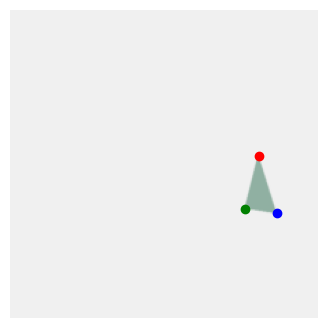

In [ ]:
# Display an image with keypoints on them
import matplotlib.pyplot as plt

def display_image(image, keypoints, figsize=(2,2)):
    plt.figure(figsize=figsize)
    W, H = image.shape[1], image.shape[2]
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.scatter(keypoints[0, 0]*W, keypoints[0, 1]*H, c='r')
    plt.scatter(keypoints[1, 0]*W, keypoints[1, 1]*H, c='g')
    plt.scatter(keypoints[2, 0]*W, keypoints[2, 1]*H, c='b')
    plt.show()

display_image(X, y, figsize=(4,4))

In [ ]:
train_dataset = TriangleDataset('data/', 'data/train.json', transform=transform)
valid_dataset = TriangleDataset('data/', 'data/valid.json', transform=transform)
test_dataset = TriangleDataset('data/', 'data/test.json', transform=transform)

# limit the size of dataset
TRAIN_SIZE = 1000
train_dataset = torch.utils.data.Subset(train_dataset, range(TRAIN_SIZE))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 2])
tensor(0.0196) tensor(0.9412)
tensor(0.0977) tensor(0.8965)


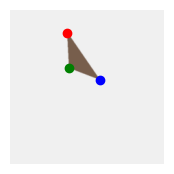

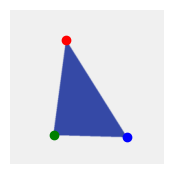

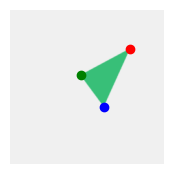

In [ ]:
# display a batch of images and their keypoints
X, y = next(iter(train_loader))
print(X.shape, y.shape)
print(X.min(), X.max())
print(y.min(), y.max())

for i in range(3):
    display_image(X[i], y[i])

## Model 1

- A pretrained CNN encoder
- A simple MLP regressor head

In [ ]:
class Model_CNN_MLP(nn.Module):
    def __init__(self):
        super(Model_CNN_MLP, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        backbone_output_size = 128*28*28
        head_hidden_size = 512
        output_size = 6 # 3 points with 2 coordinates each

        self.head = nn.Sequential(
            nn.Linear(backbone_output_size, head_hidden_size),
            nn.ReLU(),
            nn.Linear(head_hidden_size, output_size)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
import timm

class Model_Pretrained_CNN_MLP(nn.Module):
    def __init__(self, dropout_rate=0.3, head_hidden_size=512):
        super(Model_Pretrained_CNN_MLP, self).__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)
        backbone_clf_in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        self.dropout_rate = dropout_rate

        backbone_output_size = backbone_clf_in_features
        head_hidden_size = head_hidden_size
        output_size = 6 # 3 points with 2 coordinates each

        self.head = nn.Sequential(
            nn.Linear(backbone_output_size, head_hidden_size),
            # nn.BatchNorm1d(head_hidden_size),
            nn.ReLU(),
            # nn.Dropout(self.dropout_rate),
            nn.Linear(head_hidden_size, output_size)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x

In [ ]:
from tqdm.auto import tqdm

def train(model, train_loader, optimizer, criterion, running_loss, epoch):
    loss_history = []
    model.train()

    i = 0
    for (X, y) in (pbar := tqdm(train_loader)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.view(-1, 6))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * BATCH_SIZE
        # loss_history.append(running_loss/(i+1))

        # if i%5 == 0:
        #     # print(f"Batch {i}/{len(train_loader)} Loss: {running_loss/(((epoch)*len(train_loader)+(i+1))*BATCH_SIZE)}")
        loss_history.append(running_loss/(((epoch)*len(train_loader)+(i+1))*BATCH_SIZE))
        pbar.set_description(f"Batch {i}/{len(train_loader)} Loss: {running_loss/(((epoch)*len(train_loader)+(i+1))*BATCH_SIZE)}")

        # if i%5 == 0:
        #     visualize_prediction(model, test_dataset[0])
        #     plt.show()

        i += 1

    return running_loss,  loss_history

def evaluate(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    for i, (X, y) in enumerate(valid_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y.view(-1, 6))
        running_loss += loss.item()
    return running_loss / len(valid_loader)


def predict(model, sample):
    X, y = sample
    model.eval()
    with torch.no_grad():
        y_pred = model(X.unsqueeze(0).to(device))
    return y_pred.cpu().numpy()

def visualize_prediction(model, sample):
    X, y = sample
    y_pred = predict(model, sample)
    display_image(X, y_pred[0].reshape(-1, 2))


In [ ]:
model = Model_Pretrained_CNN_MLP().to(device)
# freeze backbone params
# for param in model.backbone.parameters():
#     param.requires_grad = False

In [ ]:

def freeze_upto(model, layer_index):
    """
    Freezes a model up to (and including) layer 'layer_index' from the end.

    Parameters:
    model (nn.Module): The model to freeze.
    layer_index (int): The index of the layer up to which to freeze (inclusive), counting from the end.

    Returns:
    nn.Module: The model with specified layers frozen.
    """

    # Convert the model layers to a list
    layers = list(model.children())

    # Calculate the index from the start
    start_index = len(layers) - layer_index - 1

    # Freeze all layers up to the start_index (inclusive)
    for i in range(start_index + 1):
        for param in layers[i].parameters():
            param.requires_grad = False

    return model


In [ ]:
# list(model.backbone.children())[-5]

In [ ]:
# model = freeze_upto(model, 10)

In [ ]:

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

n_epochs = 30

Epoch 1/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.03756244640680961 | Valid Loss: 0.0175


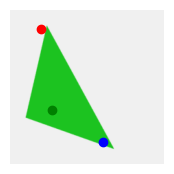



Epoch 2/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.023057675040035974 | Valid Loss: 0.0049


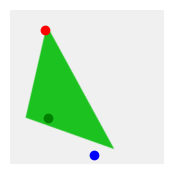



Epoch 3/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.016930988851527218 | Valid Loss: 0.0030


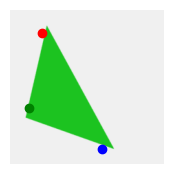



Epoch 4/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.01356338249570399 | Valid Loss: 0.0024


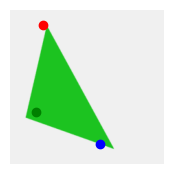



Epoch 5/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.011513720479706535 | Valid Loss: 0.0037


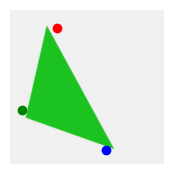



Epoch 6/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.00999570947533357 | Valid Loss: 0.0022


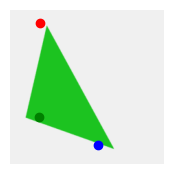



Epoch 7/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.00883565792693324 | Valid Loss: 0.0021


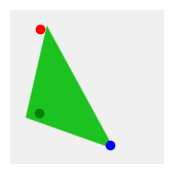



Epoch 8/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.007959402599681198 | Valid Loss: 0.0016


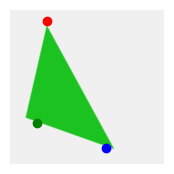



Epoch 9/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.007267920836966368 | Valid Loss: 0.0013


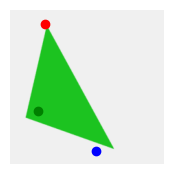



Epoch 10/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.006678201498107228 | Valid Loss: 0.0021


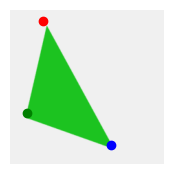



Epoch 11/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.006193688670960414 | Valid Loss: 0.0012


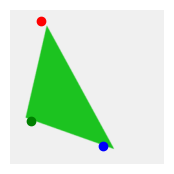



Epoch 12/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.005763384293459239 | Valid Loss: 0.0012


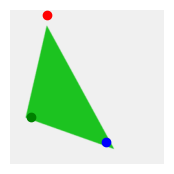



Epoch 13/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.005444533520158774 | Valid Loss: 0.0029


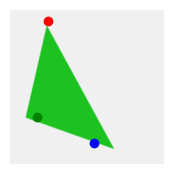



Epoch 14/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.005216370789120057 | Valid Loss: 0.0026


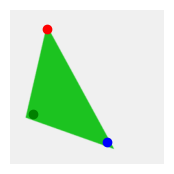



Epoch 15/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.004991487526179602 | Valid Loss: 0.0024


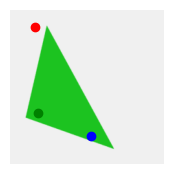



Epoch 16/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.004767491820530267 | Valid Loss: 0.0028


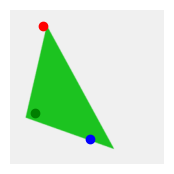



Epoch 17/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.004548090458817622 | Valid Loss: 0.0012


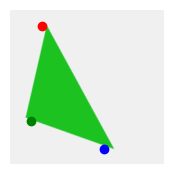



Epoch 18/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.004349443598787022 | Valid Loss: 0.0011


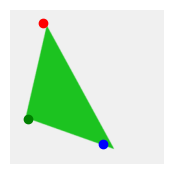



Epoch 19/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.004152897878348564 | Valid Loss: 0.0014


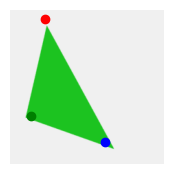



Epoch 20/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.0039752296148435565 | Valid Loss: 0.0006


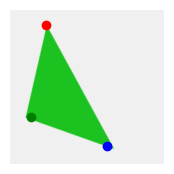



Epoch 21/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.003806218215469839 | Valid Loss: 0.0007


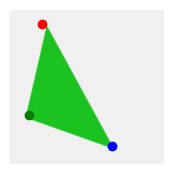



Epoch 22/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.0036539053959669136 | Valid Loss: 0.0009


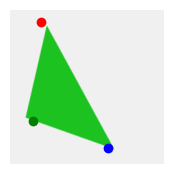



Epoch 23/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.003516948599751587 | Valid Loss: 0.0008


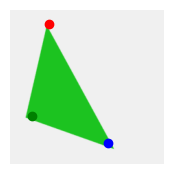



Epoch 24/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.003387769414473496 | Valid Loss: 0.0006


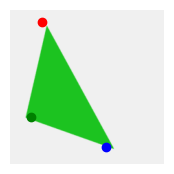



Epoch 25/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.0032663835620405732 | Valid Loss: 0.0006


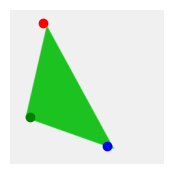



Epoch 26/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.0031549454950331544 | Valid Loss: 0.0007


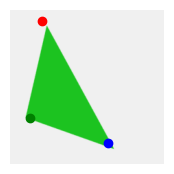



Epoch 27/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.00305540727083132 | Valid Loss: 0.0006


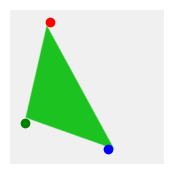



Epoch 28/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.00295964811995678 | Valid Loss: 0.0007


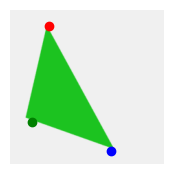



Epoch 29/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.0028703597877054185 | Valid Loss: 0.0006


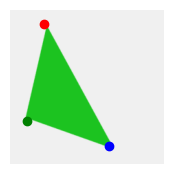



Epoch 30/30


  0%|          | 0/32 [00:00<?, ?it/s]

train_loss: 0.0027884108994991647 | Valid Loss: 0.0007


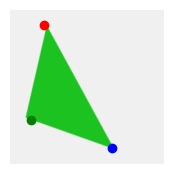

In [ ]:
loss_history_global = []
train_loss = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_loss, history = train(model, train_loader, optimizer, criterion, train_loss, epoch)
    valid_loss = evaluate(model, valid_loader, criterion)
    loss_history_global = loss_history_global + history
    print(f"train_loss: {train_loss/((epoch+1)*len(train_loader)*BATCH_SIZE)} | Valid Loss: {valid_loss:.4f}")
    visualize_prediction(model, test_dataset[0])
    print()
    print()
    plt.show()

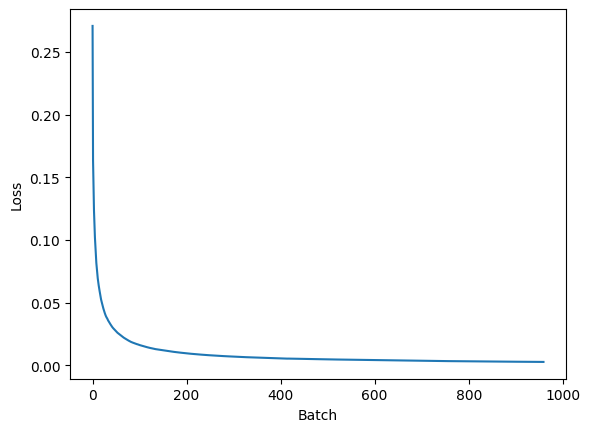

In [ ]:
plt.plot(loss_history_global)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

In [ ]:
predict(model, test_dataset[0])

array([[0.21590301, 0.09570669, 0.13681522, 0.7138529 , 0.66010994,
        0.89497465]], dtype=float32)

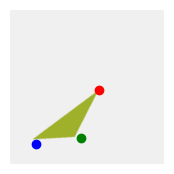

In [ ]:
visualize_prediction(model, test_dataset[9])

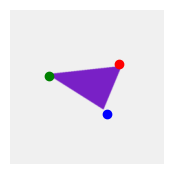

In [ ]:
visualize_prediction(model, test_dataset[3])

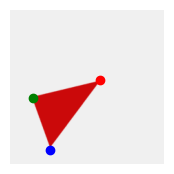

In [ ]:
visualize_prediction(model, test_dataset[4])